# PAMTRA full-bin interface example with ACME-V data

Here, we show how PAMTRA can be be used with measured, binned particle size distributions. This is not only applicable to in situ measurements, but also to atmospheric models with full bin microphysics. 

Start with importing the required libraries and setting up the Notebook to show plots inline.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pyPamtra

%matplotlib inline

Open the ACME-V data set (https://uni-koeln.sciebo.de/s/dH5DJROEZYVUNsR). To keep file size small, the file contains only observations of a single cloud. See Maahn et al. (2017, https://doi.org/10.5194/acp-17-14709-2017) for details of the processing. 

In [43]:
acmeV = xr.open_dataset('data/acmev_dataset_for_pamtra.nc')

In [44]:
acmeV

<xarray.Dataset>
Dimensions:                                     (datetime: 109, 2DS_Dmean: 61, 2DS_Dbound: 62, FCDP_Dmean: 21, FCDP_Dbound: 22, CDP_Dbound: 31, CDP_Dmean: 30, HVPS_Dmean: 37, HVPS_Dbound: 38, PCASP_Dmean: 30, PCASP_Dbound: 31, SP2_binBounds: 201, SP2_bin: 200, UHSAS_Dmean: 87, UHSAS_Dbound: 88, IsoOPC_Dbound: 41, IsoOPC_Dmean: 40, mergedIL_Dmean: 101, mergedIL_phase: 2, mergedIL_habits: 10, mergedIL_Dbound: 102)
Coordinates: (12/21)
  * datetime                                    (datetime) datetime64[ns] 201...
  * 2DS_Dmean                                   (2DS_Dmean) float64 10.0 ... inf
  * 2DS_Dbound                                  (2DS_Dbound) float64 5.0 ... inf
  * FCDP_Dmean                                  (FCDP_Dmean) float64 0.75 ......
  * FCDP_Dbound                                 (FCDP_Dbound) float64 0.0 ......
  * CDP_Dbound                                  (CDP_Dbound) float64 2.0 ... ...
    ...                                          ...
  * IsoOPC_Dbound                               (IsoOPC_Dbound) float64 0.5 ....
  * IsoOPC_Dmean                                (IsoOPC_Dmean) float64 0.715 ...
  * mergedIL_Dmean                              (mergedIL_Dmean) float64 2.25...
  * mergedIL_phase                              (mergedIL_phase) |S6 b'liquid...
  * mergedIL_habits                             (mergedIL_habits) |S9 b'spher...
  * mergedIL_Dbound                             (mergedIL_Dbound) float64 1.5...
Data variables: (12/209)
    IWG1                                        (datetime) |S4 ...
    Lat                                         (datetime) float64 ...
    Lon                                         (datetime) float64 ...
    GPS_MSL_Alt                                 (datetime) int64 ...
    WGS_84_Alt                                  (datetime) int64 ...
    Press_Alt                                   (datetime) int64 ...
    ...                                          ...
    mergedIL_mean_10s                           (datetime) float64 ...
    mergedIL_std_10s                            (datetime) float64 ...
    mergedIL_mean_phase_10s                     (datetime, mergedIL_phase) float64 ...
    mergedIL_std_phase_10s                      (datetime, mergedIL_phase) float64 ...
    mergedIL_mean_habits_10s                    (datetime, mergedIL_habits) float64 ...
    mergedIL_std_habits_10s                     (datetime, mergedIL_habits) float64 ...
Attributes:
    author:   Maximilian Maahn mmaahn@noaa.gov
    created:  2016-10-06 10:34:22.677487

Extract the drop size distribution (DSD) from the netCDF file. The largest size bin of the in situ probes is actually larger than rain drop sizes (8 mm). To avoid PAMTRA stopping with an error, we cut off the 8 largest size bins. 

In [45]:
iMax = 8
dsd = np.ma.masked_invalid(
    acmeV.mergedIL_specConc_phase_10s.values[:, :-iMax, 0]).filled(0)
nBins = np.shape(dsd)[1]

In [46]:
print(dsd.mean())

365485763118.67444


Also, we save the average and bounding diameter of each size bin

In [47]:
Dbound = acmeV.mergedIL_Dbound.values[:-iMax]
Dmean = acmeV.mergedIL_Dmean.values[:-iMax]

Next, we create an empty pyPamtra object

In [48]:
pam = pyPamtra.pyPamtra()

Even though we use the full-bin interface, we need to add a standard hydrometeor description to create the required data structures. For consistency, the same data fields are required as for the regular PAMTRA hydrometeor interface. However, many parameters are not relevant when using the full-bin interface. 

In [49]:
pam.df.addHydrometeor((
    "ice",  # name 
    -99.,  # aspect ratio (NOT RELEVANT)
    -1,  # liquid - ice flag
    -99.,  # density (NOT RELEVANT)
    -99.,  # mass size relation prefactor a (NOT RELEVANT)
    -99.,  # mass size relation exponent b (NOT RELEVANT)
    -99.,  # area size relation prefactor alpha (NOT RELEVANT)
    -99.,  # area size relation exponent beta (NOT RELEVANT)
    0,  # moment provided later (NOT RELEVANT)
    nBins,  # number of bins
    "fullBin",  # distribution name (NOT RELEVANT)
    -99.,  # distribution parameter 1 (NOT RELEVANT)
    -99.,  # distribution parameter 2 (NOT RELEVANT)
    -99.,  # distribution parameter 3 (NOT RELEVANT)
    -99.,  # distribution parameter 4 (NOT RELEVANT)
    -99.,  # minimum diameter (NOT RELEVANT)
    -99.,  # maximum diameter (NOT RELEVANT)
    'ss-rayleigh-gans',  # scattering model
    'khvorostyanov01_drops',  # fall velocity relation
    0.0  # canting angle
))

Next, we add an an atmospheric profile to PAMTRA. For this example, we use an US standard profile for simplicity. The `pyPamtra.importer.createUsStandardProfile` helper routine requires only height levels as an input. The height dimension of level properties is one longer than for layer properties such as hydrometeor properties. Therefore, we need to add one more height level to the ACME-V data set. Here, we simply add a height value to the vector. For comparison with e.g. a ground-based radar, the height levels should be derived from the height layers through interpolation. 

In [50]:
pam = pyPamtra.importer.createUsStandardProfile(
    pam, 
    hgt_lev=list(acmeV['GPS_MSL_Alt'].values) + [1067] 
)

/home/nmaherndl/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: lat set to 50.938056
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: lon set to 6.956944
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: groundtemp set to nan
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/pyth

Note that parameters not provided will be guessed, please make sure to look at the warning messages carefully. Now, the `pam.p` dictionary is created

In [51]:
sorted(pam.p.keys())

['airturb',
 'groundtemp',
 'hgt',
 'hgt_lev',
 'hydro_n',
 'hydro_q',
 'hydro_reff',
 'lat',
 'lon',
 'max_nlyrs',
 'model_i',
 'model_j',
 'ngridx',
 'ngridy',
 'nlyrs',
 'noutlevels',
 'obs_height',
 'press_lev',
 'radar_prop',
 'relhum_lev',
 'sfc_model',
 'sfc_refl',
 'sfc_salinity',
 'sfc_sif',
 'sfc_slf',
 'sfc_type',
 'temp_lev',
 'turb_edr',
 'unixtime',
 'wind10u',
 'wind10v',
 'wind_uv',
 'wind_w']

In [52]:
pam.p['hgt_lev'].shape#, pam.p['hgt_lev']

(1, 1, 110)

The temperature and pressure fields have been populated with US standard atmosphere values in K and Pa, respectively. Note that all input quantities in PAMTRA except frequency (GHz) are in SI units. Refer to `pam.units` for details.

In [53]:
pam.p['temp_lev'], pam.p['press_lev']
#print(pam.p['temp_lev'].shape)

(array([[[283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283,
          283, 283, 283, 283, 282, 282, 282, 282, 282, 282, 282, 282,
          282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282,
          282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282,
          282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282,
          282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282,
          282, 282, 282, 281, 281, 281, 281, 281, 281, 281, 281, 281,
          281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281,
          281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281,
          281, 281]]]),
 array([[[93037, 92981, 92914, 92835, 92779, 92712, 92634, 92578, 92522,
          92489, 92444, 92377, 92333, 92288, 92244, 92199, 92155, 92099,
          92044, 91977, 91922, 91866, 91822, 91777, 91733, 91711, 91700,
          91689, 91700, 91689, 91667, 91622, 91589, 91545, 91501, 91456,
          91434, 91412, 91390, 91379, 91357, 91346, 91

To model turbulence properly, we need to define the horizontal wind speed and the eddy dissipation rate (see Maahn et al. 2015, https://doi.org/10.1175/JTECH-D-14-00112.1 for details). For simplicity, we choose fixed values for this example

In [54]:
pam.p['wind_uv'][:] = 10
pam.p['turb_edr'][:] = 1e-4

Note that there is no need to specify a hydrometeor moment due to the use of the full-bin interface 

In [55]:
pam.p['hgt'] = np.array([[acmeV['GPS_MSL_Alt'].values]])

In [56]:
pam.p['hgt'].shape

(1, 1, 109)

We set some non-default settings, see the documentation (https://pamtra.readthedocs.io/en/latest/settings.html) for details. Note the `pam.nmlSet["hydro_fullspec"] = True` which tells the Python Fortran kernel to use the provided distributions instead of the parameters of the hydrometeor description.

In [57]:
pam.nmlSet["passive"] = False
pam.nmlSet["randomseed"] = 0
pam.nmlSet["radar_mode"] = "spectrum"
pam.nmlSet["radar_aliasing_nyquist_interv"] = 3
pam.nmlSet["hydro_adaptive_grid"] = False
pam.nmlSet["conserve_mass_rescale_dsd"] = False
pam.nmlSet["radar_use_hildebrand"] = True
pam.nmlSet["radar_noise_distance_factor"] = -2
pam.nmlSet["hydro_fullspec"] = True

For debugging, verbosity of the Fortran and Python code can be increased. Note that due to technical limitations (https://github.com/ipython/ipykernel/issues/110) the output of the Fortran kernel does not show up in Jupyter. For debugging the Fortran kernel, you can start `iPython` in a terminal and run this script with `%run fullbin-acmev-example.ipynb` to see the debugging output.

In [58]:
pam.set["verbose"] = 0
pam.set["pyVerbose"] = 0

Finally, we create the Python objects for the measured DSDs

In [59]:
pam.df.addFullSpectra()

which creates the `pam.df.dataFullSpec` dictionary containing empty arrays which need to be populated 

In [60]:
list(pam.df.dataFullSpec.keys())

['rho_ds',
 'd_ds',
 'd_bound_ds',
 'n_ds',
 'mass_ds',
 'area_ds',
 'as_ratio',
 'canting',
 'fallvelocity',
 'rg_kappa_ds',
 'rg_beta_ds',
 'rg_gamma_ds',
 'rg_zeta_ds']

We start with adding the in situ observations for `d_bound_ds` (size bin boundaries in m), `d_ds` (size bin center in m, used for scattering calculation), and `n_ds` (number concentration in 1/m$^3$). Note that the in situ data set contains a drop size distribution in 1/m$^4$ which is why we apply `np.diff(Dbound)`.

In [61]:
pam.df.dataFullSpec["d_bound_ds"][:] = Dbound
pam.df.dataFullSpec["d_ds"][:] = Dmean
pam.df.dataFullSpec["n_ds"][:] = dsd[
    np.newaxis, 
    np.newaxis,
    :, 
    np.newaxis,
    :,
] * np.diff(Dbound)

Note that the dimension of these arrays is

In [62]:
pam.df.dataFullSpec["n_ds"].shape

(1, 1, 109, 1, 93)

which is for x-dimension, y-dimension, height, hydrometeor type (in case there are more than one), and size bin. Therefore, `np.newaxis` needs to be used for the measured DSDs to allow broadcasting to the required shape. 

It is crucial to define also the other hydrometeor properties `rho_ds` (particle density in kg/m$^3$), `area_ds` (cross section area in m$^2$), `mass_ds` (particle mass in kg), and `as_ratio` (aspect ratio, oblate for values < 1). However, for liquid cloud and drizzle drops, the trivial relations for spheres can be used. This give the opportunity to use arbitrarily complex relations for ice and snow particles. Note that it is the sole responsibility of the user to make sure all relations are consistent with each other, unless in PAMTRA's normal mode, the full-bin interface does not do any consistency checks. 

In [112]:
ssrga_paras = pyPamtra.riming.ssrga_parameter(1)
ssrga_paras

(0.162, 2.0299999999999994, 3.28, 0.10300000000000001, 0.9219999999999999)

In [113]:
ssrga_paras[4]

0.9219999999999999

In [114]:
pam.df.dataFullSpec["rho_ds"][:] = 1000.
pam.df.dataFullSpec["area_ds"][:] = (np.pi / 4. *
                                     pam.df.dataFullSpec["d_ds"][:]**2)
pam.df.dataFullSpec["mass_ds"][:] = (np.pi / 6. *
                                     pam.df.dataFullSpec["rho_ds"][:] *
                                     pam.df.dataFullSpec["d_ds"][:]**3)

pam.df.dataFullSpec["as_ratio"][:] = ssrga_paras[4]
pam.df.dataFullSpec["rg_kappa_ds"][:] = ssrga_paras[0]
pam.df.dataFullSpec["rg_beta_ds"][:] = ssrga_paras[1]
pam.df.dataFullSpec["rg_gamma_ds"][:] = 4#ssrga_paras[2]
pam.df.dataFullSpec["rg_zeta_ds"][:] = ssrga_paras[3]

Finally, we can run PAMTRA for the intended frequencies to estimate the radar observables. It is recommended to check whether `pam.fortError == 0` after running PAMTRA to catch errors in the Fortran part which are not displayed in Jupyter as discussed above. 

In [115]:
frequencies = [35.5]
pam.runPamtra(frequencies)
print((pam.fortError))

0


Now, we can analyze the results which are stored in the `pam.r` dictionary.

In [24]:
list(pam.r.keys())

['tb',
 'Ze',
 'emissivity',
 'Att_hydro',
 'Att_atmo',
 'radar_hgt',
 'radar_moments',
 'radar_edges',
 'radar_slopes',
 'radar_quality',
 'radar_snr',
 'radar_spectra',
 'radar_vel',
 'psd_d',
 'psd_deltad',
 'psd_n',
 'psd_mass',
 'psd_area',
 'psd_bscat',
 'kextatmo',
 'scatter_matrix',
 'extinct_matrix',
 'emis_vector',
 'angles_deg',
 'pamtraVersion',
 'pamtraHash',
 'nmlSettings']

For plotting, we extract the Doppler velocity bins `pam.r['radar_vel']`, the height layers `pam.p['hgt']`, the calculated radar Doppler spectrum `pam.r['radar_spectra']`, and radar reflectivity `pam.r['Ze']`.

In [25]:
pam_velocity = pam.r['radar_vel'].squeeze()
pam_height = pam.p['hgt'].squeeze()
pam_spectra = pam.r['radar_spectra'].squeeze()
Ze = pam.r['Ze'].squeeze()

For comparison, we compare this to the effective diameter `acmev_deff` (defined analogue to the effective radius) and the  measured DSD `acmev_dsd` in log$_{10}$  scale. We mask particle concentrations below 10$^{-5}$ 1/m$^{-4}$ for better plotting because these small concentrations are related to instrument noise.

In [26]:
acmev_deff = (np.nansum(dsd * Dmean**3, axis=1) /
              np.nansum(dsd * Dmean**2, axis=1))
acmev_height = acmeV['GPS_MSL_Alt'].values
acmev_dsd = np.log10(dsd)
acmev_dsd = np.ma.masked_array(acmev_dsd, acmev_dsd < 5)

/tmp/ipykernel_33867/2896316418.py:4: RuntimeWarning: divide by zero encountered in log10
  acmev_dsd = np.log10(dsd)


Create the plot shown in the paper. Note the artifacts in the DSD caused by the different sensitivities of the cloud probes. 

/tmp/ipykernel_33867/2110321425.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pm = ax1.pcolormesh(Dmean, acmev_height, acmev_dsd, rasterized=True, vmin=-5)
/tmp/ipykernel_33867/2110321425.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pm = ax2.pcolormesh(pam_velocity,


Text(0.5, 0, 'Radar reflectivity factor (black) $Z_e$ [dBz]')

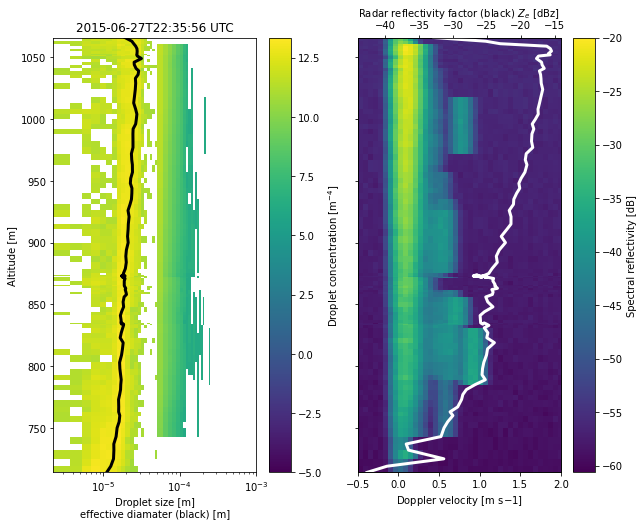

In [27]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10, 8), sharey=True)

pm = ax1.pcolormesh(Dmean, acmev_height, acmev_dsd, rasterized=True, vmin=-5)
plt.colorbar(pm, label='Droplet concentration [m$^{-4}$]', ax=ax1)
ax1.plot(acmev_deff, acmev_height, c='k', lw=3)

ax1.set_xscale('log')
ax1.set_title('%s UTC' % str(acmeV.datetime[0].values).split('.')[0])
ax1.set_xlabel('Droplet size [m]\neffective diamater (black) [m]')
ax1.set_ylabel('Altitude [m]')
ax1.set_xlim(Dmean.min(),1e-3)

pm = ax2.pcolormesh(pam_velocity,
                    pam_height,
                    pam_spectra,
                    vmax=-20,
                    rasterized=True)
plt.colorbar(pm, label='Spectral reflectivity [dB]', ax=ax2)

ax2.set_xlim(-0.5, 2)
ax2.set_xlabel('Doppler velocity [m s$-1$]')

ax2t = ax2.twiny()
ax2t.plot(Ze, pam_height, c='w', lw=3)
ax2t.set_ylim(pam_height.min(), pam_height.max())
ax2t.set_xlabel('Radar reflectivity factor (black) $Z_e$ [dBz]')